# Discretizing GeoLife Trajectory 1.3 sample data into a spatiotemporal grid

*Part of the COVID19risk project*  
*http://covid19risk.com/*  
*2020-03-04*  

*Copyright (C) 2020 Mikhail Voloshin, Mighty Data Inc.*  
*All rights reserved.*  

The objective of this Notebook is to convert the sample GeoLife trajectory data from Microsoft (https://www.microsoft.com/en-us/download/details.aspx?id=52367) into a form that can be marshalled to a browser for purposes of being rendered client-side as a heatmap that can be navigated across space and time.

The GeoLife data is hundreds of megabytes ZIPped, and over 1.5 GB expanded into CSV-based "trajectory" files. This is far too big and too detailed to be usable by a client.

As such, the purpose of this Notebook is to create a "summary" of the data that is optimized for rendering as a geospatial map, such as an overlap atop Google Maps.

This is achieved via the following approach:
 1. The user specifies a spatial resolution, in kilometers (default 5). Note that, because the Earth is round, this will only be approximately accurate. It will be optimized for best performance near the central US. Cells will grow finer (smaller, so fewer data points fall into each cell) closer to the poles, and coarser (larger, so more data points fall into individual cells) closer to the equator. Later adaptations of this software can compute cell boundaries more accurately.
 1. The user specifies a temporal resolution, in days (default 7)
 1. The user specifies a data directory into which the Microsoft Research GeoLife ZIP file got unzipped. If the directory name is the same as the filename, then this directory will be called "Geolife Trajectories 1.3"
 1. This script will discretize the trajectory data into this grid. This script will iterate over every data point in every trajectory in the data directory, determine which spatiotemporal grid cell the point falls into, and tally the total number of unique trajectories (individuals) who appear in each cell.
 1. The resultant tallies will be output as a time series of heatmaps. Each heatmap is inferred to be sparse, so it will be represented as a map; keys representing the latitude and longitude of each cell map to the number of trajectories tallied in that cell for that time interval.
 

## Define parameters

In [1]:
# Define parameters

# The number of kilometers covered by each grid cell, in both the latitude and longitude direction.
# Discretization is zeroed on the equator and prime meridian for latitude and longitude respectively.
# For now, the number of kilometers per degree is fixed at a conversion rate optimized for 40oN -100oW,
# which lies in northern Kansas near the geospatial center of the US. Future versions of this
# script will employ an algorithm that takes the Earth's curvature into account. For now, this will lead
# to a slight illusory increase in data points per cell (i.e. deceptively "hotter" cells) near
# the equator, and an illusory decrease in data points per cell (i.e. deceptively "colder" cells)
# near the poles. The distortion near the poles will be significant, but because those are far from
# human population centers this should be acceptable.
GRID_SPATIAL_KM = 5

# The number of days for each time step into which to discretize the data.
# Discretization is zeroed on the Unix epoch.
GRID_TEMPORAL_DAYS = 7

# Path to the unzipped Geolife data folder.
DATA_DIR = "../../../../data/proof-of-concept/Geolife Trajectories 1.3"

## Search for trajectory files

In [2]:
import os

if not os.path.isdir(DATA_DIR):
    raise ValueError(DATA_DIR + " doesn't appear to be a directory that exists on this filesystem.")
if not os.path.isdir(DATA_DIR+'/Data'):
    raise ValueError(DATA_DIR + " doesn't appear to be the unzipped Geolife dataset. It doesn't contain a /Data subdirectory.")

# A trajectory folder path is any subfolder of the Data directory that has a Trajectory subfolder.
trajectory_folder_paths = [f.path for f in os.scandir(DATA_DIR+'/Data') if f.is_dir() and os.path.isdir(f.path+'/Trajectory')]

print(f'Success. {len(trajectory_folder_paths)} trajectories found.')

Success. 182 trajectories found.


## Initialize the data structures we'll output

In [3]:
cell_spatiotemporal_tallies = {}

## Precompute some values that will be useful to us during the computation

Spatial grid degrees were computed with the help of https://andrew.hedges.name/experiments/haversine/. Future versions of this script should use trigonometry to discretize by traversing a longitudinal line in intervals of *GRID_SPATIAL_KM* km steps from the equator, and then using the Earth's cross-section at that latitude to walk by *GRID_SPATIAL_KM* km steps from the prime meridian. It's not hard, but a little too tedious to go through the trouble of writing said function for this proof-of-concept stage.

In [4]:
CELLSIZE_SECONDS = GRID_TEMPORAL_DAYS * 24 * 60 * 60

CELLSIZE_DEGREES_LAT = GRID_SPATIAL_KM * 0.00899
CELLSIZE_DEGREES_LONG = GRID_SPATIAL_KM * 0.01174
CELLSIZE_DEGREES_PRECISION = 5


## Define some helper functions

In [5]:
import time
import datetime

MICROSOFT_EPOCH_START = time.mktime(datetime.datetime.strptime('1899-12-30', '%Y-%m-%d').timetuple())

def convert_microsoft_epoch_to_unixtime(dayscount):
    # Microsoft Research encoded this dataset to include a field
    # that contains the number of days that have elapsed since
    # Dec 30 (not 31), 1899. No word on whether this is midnight
    # at the *beginning* or *end* of said date, but we can validate
    # against the other date and time columns to make sure we
    # got it right (which we did).

    secondscount = dayscount * 24 * 60 * 60
    retval = MICROSOFT_EPOCH_START + secondscount
    return int(retval)
    


In [6]:
latlong_fstring_part = f'{{:.{CELLSIZE_DEGREES_PRECISION}f}}'
latlong_fstring = f'{latlong_fstring_part},{latlong_fstring_part}'

def determine_grid_cell(df):
    df['unixtime'] = df['daysSinceMicrosoftEpoch'].apply(convert_microsoft_epoch_to_unixtime)    
    
    # We're using int as a de facto math.floor function
    df['cell_latitude'] = (df['latitude'] / CELLSIZE_DEGREES_LAT).apply(int) * CELLSIZE_DEGREES_LAT
    df['cell_longitude'] = (df['longitude'] / CELLSIZE_DEGREES_LONG).apply(int) * CELLSIZE_DEGREES_LONG
    df['cell_unixtime'] = (df['unixtime'] / CELLSIZE_SECONDS).apply(int) * CELLSIZE_SECONDS

    df['cell_key_spatial'] = df.apply(lambda x: latlong_fstring.format(x['cell_latitude'], x['cell_longitude']), axis=1)
    df['cell_key_spatiotemporal'] = df.apply(lambda x: '{},{}'.format(x['cell_key_spatial'], x['cell_unixtime']), axis=1)
    
    return df
    

## Populate our data structures
This script should take about half an hour to run on a 2.8 Ghz Lenovo laptop with 16 GB RAM.

In [7]:
%%time

print(f'Started at {datetime.datetime.now()}')

import pandas as pd

# The column meanings come from the User Guide PDF that comes with the Geolife dataset.
GEOLIFE_COLUMNS = [
    'latitude',
    'longitude',
    'reserved0',
    'altitude',
    'daysSinceMicrosoftEpoch',
    'date',
    'time'    
]


for traj_path in trajectory_folder_paths:
    traj_id = traj_path.split('/')[-1]
    print(f'Processing Trajectory ID: {traj_id}')

    cells_hit_by_this_traj = set()
    
    traj_filenames = [f.path for f in os.scandir(traj_path+'/Trajectory') if f.is_file() and f.path.endswith('.plt')]
    print(f'{len(traj_filenames)} trajectory plots found.')
    
    for traj_filename in traj_filenames:
        df = pd.read_csv(traj_filename, skiprows=6, names=GEOLIFE_COLUMNS)
        determine_grid_cell(df)
        cells_hit = set(df['cell_key_spatiotemporal'].unique())
        cells_hit_by_this_traj.update(cells_hit)
        print(".", end="")
    
    for cellkey in cells_hit_by_this_traj:
        if cellkey not in cell_spatiotemporal_tallies:
            cell_spatiotemporal_tallies[cellkey] = 1
        else:
            cell_spatiotemporal_tallies[cellkey] += 1

            
    print(f'\nTrajectory ID {traj_id} done.\n')


Started at 2020-03-04 18:49:54.040358
Processing Trajectory ID: 000
171 trajectory plots found.
...........................................................................................................................................................................
Trajectory ID 000 done.

Processing Trajectory ID: 001
71 trajectory plots found.
.......................................................................
Trajectory ID 001 done.

Processing Trajectory ID: 002
175 trajectory plots found.
...............................................................................................................................................................................
Trajectory ID 002 done.

Processing Trajectory ID: 003
322 trajectory plots found.
............................................................................................................................................................................................................................................

....................................................................................................................................................
Trajectory ID 037 done.

Processing Trajectory ID: 038
110 trajectory plots found.
..............................................................................................................
Trajectory ID 038 done.

Processing Trajectory ID: 039
227 trajectory plots found.
...................................................................................................................................................................................................................................
Trajectory ID 039 done.

Processing Trajectory ID: 040
27 trajectory plots found.
...........................
Trajectory ID 040 done.

Processing Trajectory ID: 041
557 trajectory plots found.
.........................................................................................................................................................

...........................................................................................................................................................................................................................................................................................................................................................................................................................................
Trajectory ID 085 done.

Processing Trajectory ID: 086
6 trajectory plots found.
......
Trajectory ID 086 done.

Processing Trajectory ID: 087
8 trajectory plots found.
........
Trajectory ID 087 done.

Processing Trajectory ID: 088
59 trajectory plots found.
...........................................................
Trajectory ID 088 done.

Processing Trajectory ID: 089
64 trajectory plots found.
................................................................
Trajectory ID 089 done.

Processing Trajectory ID: 090
8 trajectory plots found.
........
Trajectory ID 0

....................
Trajectory ID 130 done.

Processing Trajectory ID: 131
21 trajectory plots found.
.....................
Trajectory ID 131 done.

Processing Trajectory ID: 132
6 trajectory plots found.
......
Trajectory ID 132 done.

Processing Trajectory ID: 133
5 trajectory plots found.
.....
Trajectory ID 133 done.

Processing Trajectory ID: 134
75 trajectory plots found.
...........................................................................
Trajectory ID 134 done.

Processing Trajectory ID: 135
13 trajectory plots found.
.............
Trajectory ID 135 done.

Processing Trajectory ID: 136
17 trajectory plots found.
.................
Trajectory ID 136 done.

Processing Trajectory ID: 137
1 trajectory plots found.
.
Trajectory ID 137 done.

Processing Trajectory ID: 138
18 trajectory plots found.
..................
Trajectory ID 138 done.

Processing Trajectory ID: 139
19 trajectory plots found.
...................
Trajectory ID 139 done.

Processing Trajectory ID: 140
380 t

....................................
Trajectory ID 169 done.

Processing Trajectory ID: 170
5 trajectory plots found.
.....
Trajectory ID 170 done.

Processing Trajectory ID: 171
5 trajectory plots found.
.....
Trajectory ID 171 done.

Processing Trajectory ID: 172
21 trajectory plots found.
.....................
Trajectory ID 172 done.

Processing Trajectory ID: 173
6 trajectory plots found.
......
Trajectory ID 173 done.

Processing Trajectory ID: 174
70 trajectory plots found.
......................................................................
Trajectory ID 174 done.

Processing Trajectory ID: 175
4 trajectory plots found.
....
Trajectory ID 175 done.

Processing Trajectory ID: 176
8 trajectory plots found.
........
Trajectory ID 176 done.

Processing Trajectory ID: 177
1 trajectory plots found.
.
Trajectory ID 177 done.

Processing Trajectory ID: 178
1 trajectory plots found.
.
Trajectory ID 178 done.

Processing Trajectory ID: 179
71 trajectory plots found.
....................

In [13]:
# Save the intermediary data to a file so that we don't have to wait
# half an hour again if we shut down our kernel and resume experimentation.

import json
with open('cell_spatiotemporal_tallies.json', 'w') as f:
    json.dump(cell_spatiotemporal_tallies, f, indent=4)

## Sanity-check and visualize the data
Let's see if this data looks like something that will look good in a heatmap plot.

In [35]:
tallybuckets = {}
for cellkey, celltally in cell_spatiotemporal_tallies.items():
    if celltally not in tallybuckets:
        tallybuckets[celltally] = 1
    else:
        tallybuckets[celltally] += 1

tallybucket_keys = [int(x) for x in tallybuckets.keys()]
tallybucket_keys.sort()

tallybucket_values = [tallybuckets[x] for x in tallybucket_keys]

tallydf = pd.DataFrame(tallybucket_values, index=tallybucket_keys, columns=['num_cells'])
tallydf

,num_cells
1,39538
2,4690
3,1303
4,412
5,287
6,182
7,130
8,94
9,74
10,48


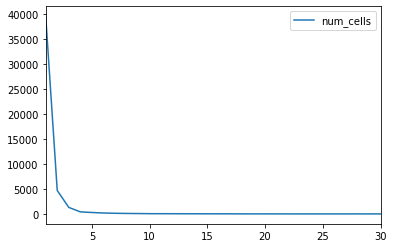

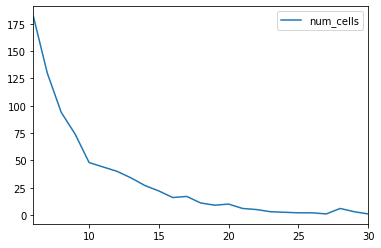

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

tallydf.plot()
tallydf[5:].plot()

## Reorganize the data into a sequence of temporal frames.
A more natural, client-friendly way to view the data is as a set of sparse heatmaps organized by the temporal cell index. So we'll re-extract the lat, long, and unixtime from the keys, and instead we'll build a dict of dicts with the unixtime as the first index.

In [38]:
heatmaps_by_unixtime = {}
for cellkey, celltally in cell_spatiotemporal_tallies.items():
    # Extract the components of the cellkey.
    # They're still strings, so they don't need
    # any further conversion to be used as subkeys.
    cell_lat, cell_long, cell_unixtime = cellkey.split(',')

    if cell_unixtime not in heatmaps_by_unixtime:
        heatmaps_by_unixtime[cell_unixtime] = {}
        
    heatmap = heatmaps_by_unixtime[cell_unixtime]
    
    cellkey_spatial = f'{cell_lat},{cell_long}'
    if cellkey_spatial in heatmap:
        raise ValueError(f'Spatial key {cellkey_spatial} duplicated in heatmap with temporal key {cell_unixtime}.')
    
    heatmap[cellkey_spatial] = celltally

print(len(heatmaps_by_unixtime))

278


## Sanity-check our reorganization
If we did this right, then we shouldn't have lost any cell tallies. Just reorganized them.

,num_cells_in_heatmap
946512000,1
1176336000,36
1176940800,44
1177545600,254
1178150400,99
...,...
1340841600,6
1341446400,4
1342051200,9
1342656000,4


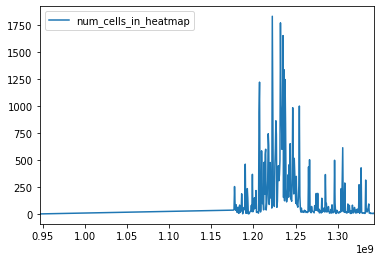

In [47]:
unixtime_keys = [int(x) for x in heatmaps_by_unixtime.keys()]
unixtime_keys.sort()

heatmap_counts = [len(heatmaps_by_unixtime[f'{x}']) for x in unixtime_keys]

heatmapsdf = pd.DataFrame(heatmap_counts, index=unixtime_keys, columns=['num_cells_in_heatmap'])
heatmapsdf.plot()
heatmapsdf

In [56]:
sanity1 = heatmapsdf['num_cells_in_heatmap'].sum()
sanity2 = len(cell_spatiotemporal_tallies)

print(sanity1)
print(sanity2)
if sanity1 != sanity2:
    raise ValueError("Our heatmap collection doesn't have the same number of cells as the spatiotemporal tally collection!")

47017
47017


## Trim garbage time slots
The Geolife data might have included some mis-entered epoch times. These will appear as time slots whose heatmap has only a single entry, with a single tally. Remove these from our data set.

In [77]:
total_tallies_by_unixtime_key = {}

for unixtime_key in unixtime_keys:
    strkey = f'{unixtime_key}'
    heatmap = heatmaps_by_unixtime[strkey]
    tally = 0
    for cellkey, celltally in heatmap.items():
        tally += celltally
    total_tallies_by_unixtime_key[strkey] = tally
    if tally <= 1:
        del heatmaps_by_unixtime[strkey]

,num_cells_in_heatmap
1176336000,36
1176940800,44
1177545600,254
1178150400,99
1178755200,34
...,...
1340841600,6
1341446400,4
1342051200,9
1342656000,4


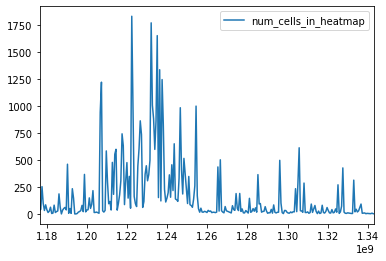

In [78]:
# Re-perform the same sanity check as above. See if the graphs look different.
unixtime_keys = [int(x) for x in heatmaps_by_unixtime.keys()]
unixtime_keys.sort()

heatmap_counts = [len(heatmaps_by_unixtime[f'{x}']) for x in unixtime_keys]

heatmapsdf = pd.DataFrame(heatmap_counts, index=unixtime_keys, columns=['num_cells_in_heatmap'])
heatmapsdf.plot()
heatmapsdf

,total_tallies_in_timecell
1176336000,57
1176940800,66
1177545600,265
1178150400,119
1178755200,41
...,...
1340841600,6
1341446400,4
1342051200,9
1342656000,4


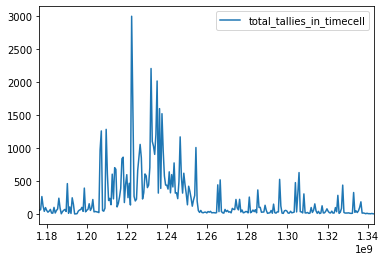

In [79]:
tallies_ordered_in_time = [total_tallies_by_unixtime_key[f'{x}'] for x in unixtime_keys]
talliesdf = pd.DataFrame(tallies_ordered_in_time, index=unixtime_keys, columns=['total_tallies_in_timecell'])

talliesdf.plot()
talliesdf

## Sanity-check our end-to-end time interval
If everything is working perfectly, we'll have a timeslot for every time step between our min and max unix times. If this isn't the case, then it's okay -- maybe Geolife data doesn't cover every time slot. But it should at least be close

In [83]:
unixtime_keys = [int(x) for x in heatmaps_by_unixtime.keys()]
unixtime_keys.sort()

print(f'Earliest timestamp: {unixtime_keys[0]}')
print(f'Last timestamp:     {unixtime_keys[-1]}')

unixtime_spanned = unixtime_keys[-1] - unixtime_keys[0]
print(f'Seconds spanned: {unixtime_spanned}')

intervals_spanned = int(unixtime_spanned / CELLSIZE_SECONDS) + 1
print(f'Intervals spanned: {intervals_spanned}')

print(f'# unixtimes: {len(unixtime_keys)}')

Earliest timestamp: 1176336000
Last timestamp:     1343260800
Seconds spanned: 166924800
Intervals spanned: 277
# unixtimes: 277


## Save output
Here's what we've been waiting for!

In [84]:
with open('time_series_sparse_geospatial_tallies.json', 'w') as f:
    json.dump(heatmaps_by_unixtime, f, indent=4)